Hi there! This is my first kernel dealing with textual data so any constructive feedabacks are higly appreciated.

This dataset contains data of over 7 topics namely biology, robotics, cryptography, diy, travel, cooking, robotics and physics extracted from Stack Exchange. Each of these topics except physics have been classified as to which topic data belongs. So our task is to do predictions on unseen physics questions.

Since our data won't be related to each other for example tags in travel won't be related to tags in cryptography hence I will be using unsupervised learning on physics dataset which is the test dataset. 

In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer 

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics import jaccard_score
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA.csv', 'preprocessed_data.csv']


Making dictionary to put all the data in the same hood.

In [2]:
data=pd.read_csv('input/JIRA.csv')
data.head()

,Summary,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project lead id,...,Comment.64,Comment.65,Comment.66,Comment.67,Comment.68,Comment.69,Comment.70,Parent,Parent summary,Status Category
0,[UE4] Login with launcher doesn't work on /iam...,CORE-4143,55519,Bug,To Do,CORE,Justice - Core Team,software,William Wu,6087d092f558240070f6be91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
1,[Unity] Login with launcher doesn't work on /i...,CORE-4142,55518,Bug,To Do,CORE,Justice - Core Team,software,William Wu,6087d092f558240070f6be91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
2,[SDK][Achievement] Fix Difference Achievement ...,CORE-4092,55196,Bug,Code Review,CORE,Justice - Core Team,software,William Wu,6087d092f558240070f6be91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
3,[SDK][Unity][Achievement] Fix Achievement Inte...,CORE-4090,55188,Bug,To Do,CORE,Justice - Core Team,software,William Wu,6087d092f558240070f6be91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
4,[AP] Admin unable to publish store use Chinese...,CORE-4082,55103,Bug,To Do,CORE,Justice - Core Team,software,William Wu,6087d092f558240070f6be91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do


In [3]:
cols_of_interest=["Summary","Issue key","Issue id","Status","Project key","Project type","Description","Priority","Resolution","Assignee","Created","Updated","Last Viewed","Resolved","Issue Type", "Custom field (Bug Location)"]
data=data[cols_of_interest]
print(data.shape)
data.head()

(631, 16)


,Summary,Issue key,Issue id,Status,Project key,Project type,Description,Priority,Resolution,Assignee,Created,Updated,Last Viewed,Resolved,Issue Type,Custom field (Bug Location)
0,[UE4] Login with launcher doesn't work on /iam...,CORE-4143,55519,To Do,CORE,software,The current SDK version breaks integration wit...,P1,NaN,William Wu,16/Jul/21 2:56 AM,18/Jul/21 8:39 PM,20/Jul/21 9:29 PM,NaN,Bug,NaN
1,[Unity] Login with launcher doesn't work on /i...,CORE-4142,55518,To Do,CORE,software,The current SDK version breaks integration wit...,P1,NaN,William Wu,16/Jul/21 2:55 AM,18/Jul/21 8:39 PM,20/Jul/21 9:29 PM,NaN,Bug,NaN
2,[SDK][Achievement] Fix Difference Achievement ...,CORE-4092,55196,Code Review,CORE,software,"Example of Backend model:\r\n{\r\n ""id"": ""60...",P1,NaN,Diar Fahruddin S,13/Jul/21 11:49 PM,19/Jul/21 11:34 PM,20/Jul/21 9:29 PM,NaN,Bug,SDK
3,[SDK][Unity][Achievement] Fix Achievement Inte...,CORE-4090,55188,To Do,CORE,software,The Achievement integration test is failed in ...,P1,NaN,Diar Fahruddin S,13/Jul/21 11:08 PM,20/Jul/21 8:33 PM,20/Jul/21 9:29 PM,NaN,Bug,NaN
4,[AP] Admin unable to publish store use Chinese...,CORE-4082,55103,To Do,CORE,software,!bandicam 2021-07-13 15-07-15-064.mp4|width=19...,P1,NaN,NaN,13/Jul/21 1:09 AM,13/Jul/21 1:13 AM,20/Jul/21 9:29 PM,NaN,Bug,Admin Portal


In [4]:
data.dropna(subset = ["Custom field (Bug Location)"], inplace=True)

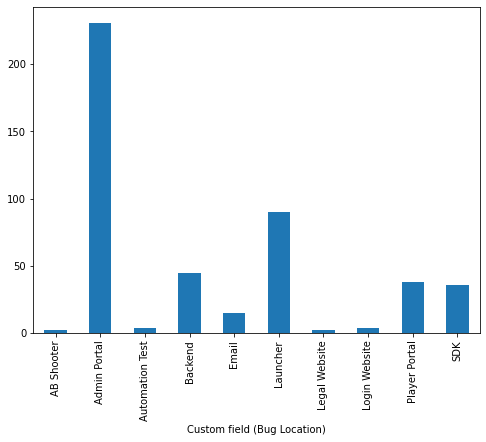

In [5]:
fig = plt.figure(figsize=(8,6))
data.groupby('Custom field (Bug Location)').Status.count().plot.bar(ylim=0)
plt.show()

In [6]:
data.Resolution = data.Resolution.fillna("Not Done")
data.isnull().sum()

Summary                         0
Issue key                       0
Issue id                        0
Status                          0
Project key                     0
Project type                    0
Description                    46
Priority                        0
Resolution                      0
Assignee                       73
Created                         0
Updated                         0
Last Viewed                     0
Resolved                       79
Issue Type                      0
Custom field (Bug Location)     0
dtype: int64

In [7]:
data.Description = data.Description.fillna("0")
data.isnull().sum()

Summary                         0
Issue key                       0
Issue id                        0
Status                          0
Project key                     0
Project type                    0
Description                     0
Priority                        0
Resolution                      0
Assignee                       73
Created                         0
Updated                         0
Last Viewed                     0
Resolved                       79
Issue Type                      0
Custom field (Bug Location)     0
dtype: int64

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

5-Vectorization (either using TfidVectorizer or Countvectorizer in sklearn.feature_extraction.text or word embeddings) Changing text data into vector format.


In [8]:
stops = set(stopwords.words("english"))

In [9]:
data.dtypes

Summary                        object
Issue key                      object
Issue id                        int64
Status                         object
Project key                    object
Project type                   object
Description                    object
Priority                       object
Resolution                     object
Assignee                       object
Created                        object
Updated                        object
Last Viewed                    object
Resolved                       object
Issue Type                     object
Custom field (Bug Location)    object
dtype: object

In [10]:
dataConcat = pd.DataFrame()
dataConcat = data['Summary']+" "+data["Custom field (Bug Location)"]+" "+ data['Description'] +" "+ data['Status'] +" "+ data['Priority'] +" "+ data['Resolution'] +" "+ data['Issue Type']
# dataConcat.to_csv("./Output/data_concat.csv")

In [11]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [12]:
# data['bug']
dataClean = pd.DataFrame()
dataClean = clean_Description(dataConcat)
dataClean.head()

2    [sdk, fix, backend, sdk, sdk, example, backend...
4    [ap, unable, publish, store, use, chinese, tra...
6    [ap, draft, store, error, message, tries, publ...
7    [ap, published, store, set, target, published,...
9    [demo, ap, cloud, save, message, add, record, ...
dtype: object

In [13]:
# desc = ' '
# for x in data.Description:
#     for y in x:
#         desc+=' '+y

In [14]:
# plt.figure(figsize=(8,10))
# wc = WordCloud(max_words=1000,random_state=1).generate(desc)
# plt.imshow(wc)
# plt.show()

In [15]:
dataClean.dtypes

dtype('O')

In [16]:
wordnet = WordNetLemmatizer()
dataClean = dataClean.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])
dataClean.head()

2    [sdk, fix, backend, sdk, sdk, example, backend...
4    [ap, unable, publish, store, use, chinese, tra...
6    [ap, draft, store, error, message, try, publis...
7    [ap, publish, store, set, target, publish, sto...
9    [demo, ap, cloud, save, message, add, record, ...
dtype: object

## Hierarchical clustering

We experiment with multiple hierarchical clustering criteria:
* Ward (maximize the decrease in intra-cluster variance with respect to all clusters)
* Single (move point to cluster of nearest neighbor)
* Complete (move point to the cluster with minimum distance to farthest point)

Ward clustering yielded reasonable results, as did complete clustering. Many cases Using the single criterion results in a degenerate case.


In [17]:
# data.Description = ','.join(str(v) for v in data.Description)
# data.head()
# data.fillna('0')
dataClean.dtypes

dtype('O')

In [18]:
Summary = dataClean.astype(str)
# Summary = str(data.summary)
# data.Summary.astype(str)
Summary.dtypes

dtype('O')

In [19]:
tfidf_vectorizer = TfidfVectorizer(lowercase=False)

In [20]:
tfidf_matrix = tfidf_vectorizer.fit_transform(Summary)
tfidf_matrix
# np.savetxt("./Output/tfidf_matrix.csv", tfidf_matrix, delimiter=",")

<467x1323 sparse matrix of type '<class 'numpy.float64'>'
	with 10946 stored elements in Compressed Sparse Row format>

In [21]:
dist = manhattan_distances(tfidf_matrix)
print(dist)
# dist = jaccard_score(tfidf_matrix)
np.savetxt("./Output/dist.csv", dist, delimiter=",")

[[0.         7.57791278 8.42621099 ... 8.40317317 7.01928881 8.45539823]
 [7.57791278 0.         6.0007913  ... 7.22755225 5.78247127 7.62419355]
 [8.42621099 6.0007913  0.         ... 7.6790878  6.48635666 8.44402497]
 ...
 [8.40317317 7.22755225 7.6790878  ... 0.         6.24518053 8.05586887]
 [7.01928881 5.78247127 6.48635666 ... 6.24518053 0.         7.25364953]
 [8.45539823 7.62419355 8.44402497 ... 8.05586887 7.25364953 0.        ]]


## Agglomerative Hierarchical Clustering

In [22]:
dist = dist - dist.min() # get rid of some pesky floating point errors that give neg. distance
linkage_matrix = complete(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

C:\Users\GF\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:356: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

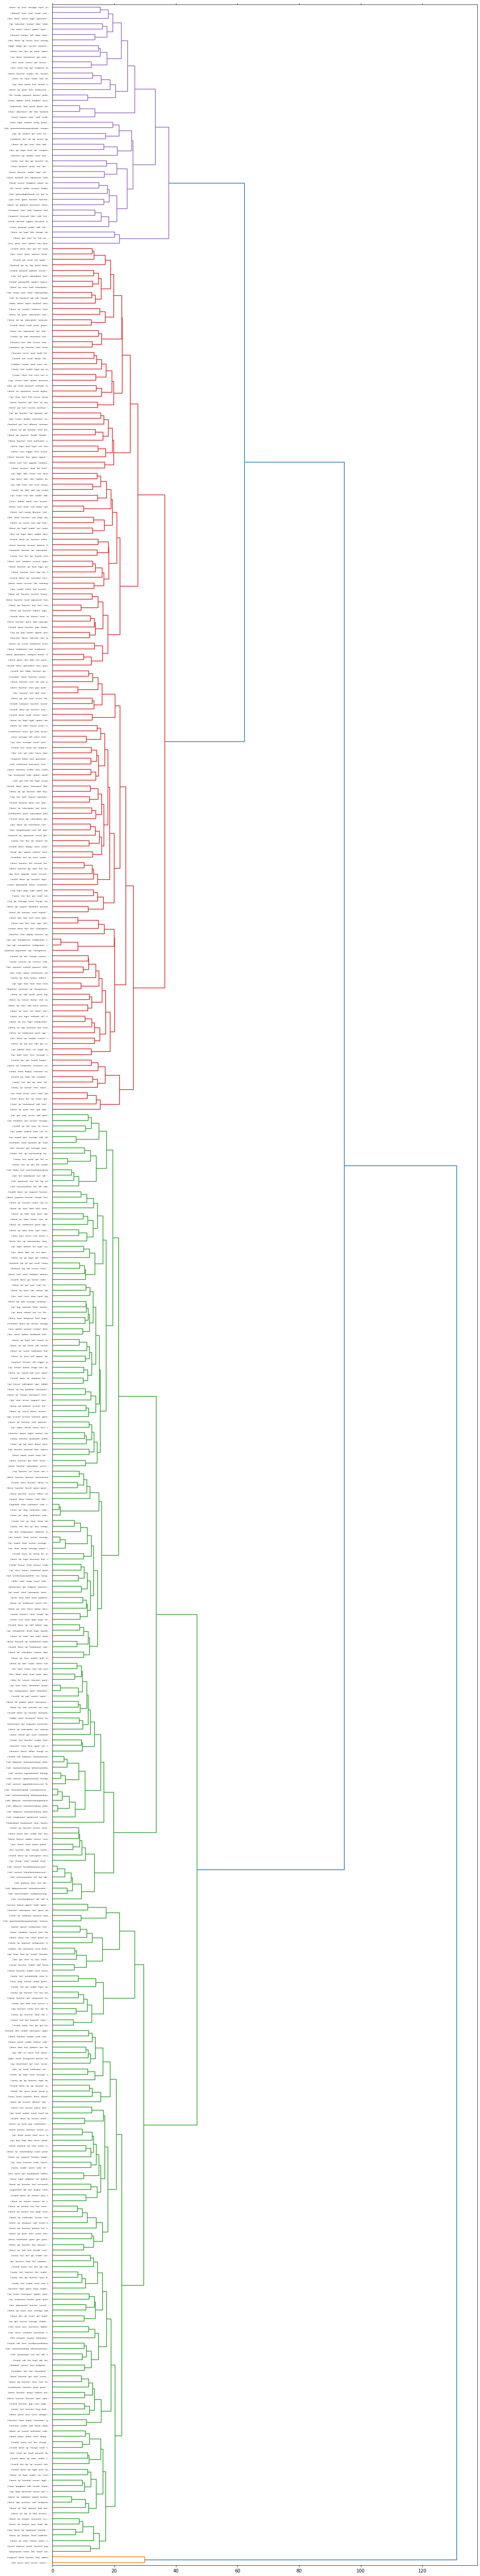

In [23]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

 Visualizing our cleaned bug data using WordCloud

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [24]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores
    

Silhouette score with 2 clusters: 0.3439197528641263
Silhouette score with 3 clusters: 0.04761234433614525
Silhouette score with 4 clusters: 0.03502955757601418
Silhouette score with 5 clusters: -0.053747767935997524
Silhouette score with 6 clusters: -0.05352215202491414
Silhouette score with 7 clusters: -0.05263648181342255
Silhouette score with 8 clusters: -0.1344531820811463
Silhouette score with 9 clusters: -0.1339946709065136
Silhouette score with 10 clusters: -0.13275299072616353
Silhouette score with 11 clusters: -0.12178414864604654
Silhouette score with 12 clusters: -0.1198785517599332
Silhouette score with 13 clusters: -0.1266600954650158
Silhouette score with 14 clusters: -0.12290290301489275
Silhouette score with 15 clusters: -0.12064413218182092
Silhouette score with 16 clusters: -0.11986708674198165
Silhouette score with 17 clusters: -0.11975436660776394
Silhouette score with 18 clusters: -0.11871642717966209
Silhouette score with 19 clusters: -0.11580867793031673
Silhoue

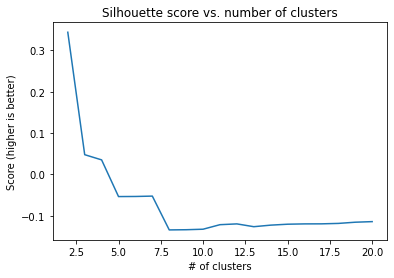

In [25]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)